Ref: https://arxiv.org/pdf/1711.10561

# Equação de Burgers

$$\left\{\begin{array}{l}
u_t + u u_x - (0.01/\pi) u_{xx} = 0, \ x \in [-1,1], \ t \in [0,1] \\
u(x,0) = -\sin(\pi x) \\
u(-1,t) = u(1,t) = 0
\end{array}\right.$$

#### Importando Bibliotecas

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn
from torch.optim.lr_scheduler import StepLR

#### Geração de Dados

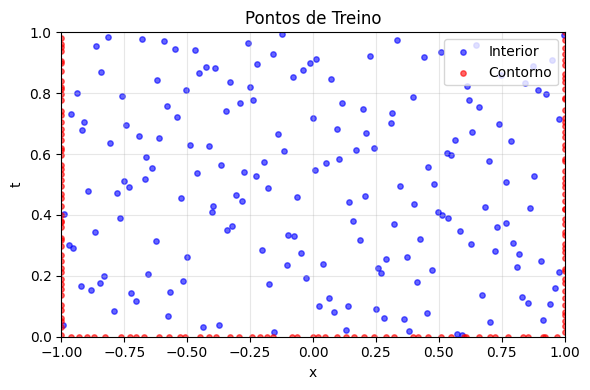

In [22]:
tc.manual_seed(21)

# Definindo domínio
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# Número de pontos
n_ci = 50  # Pra cada condição de contorno(teste)
n = 300    # Pontos usados no treino, validação e teste

distribution = [0.6, 0.2, 0.2] # Distribuição entre treino, validação e teste

# Hipercubo Latino 2D (para (x,t) ∈ [(x_min, x_max), (t_min, t_max)])
def latin_hypercube(n_points):
    intervals = tc.linspace(0, 1, n_points + 1)
    points = tc.zeros(n_points, 2)
    for i in range(2):
        perm = tc.randperm(n_points)
        points[:, i] = intervals[:-1] + (intervals[1] - intervals[0]) * tc.rand(n_points)
        points[:, i] = points[perm, i]
    
    # Escalar para o domínio definido
    points[:, 0] = points[:, 0] * (x_max - x_min) + x_min # x
    points[:, 1] = points[:, 1] * (t_max - t_min) + t_min # t
    return points

### ================================== ###
###    Condições Iniciais/Contorno     ###
### ================================== ###

# Pontos (x,t)
ci1 = latin_hypercube(n_ci)     # (x,t) = (:,0)
ci2 = latin_hypercube(n_ci)     # (x,t) = (1,:)
ci3 = latin_hypercube(n_ci)     # (x,t) = (-1,:)

ci1[:,1] = tc.zeros(n_ci)           # t = 0
ci2[:,0] = tc.full((n_ci,), 1.0)    # x = 1
ci3[:,0] = tc.full((n_ci,), -1.0)   # x = -1

treino_ci = tc.concatenate([ci1, ci2, ci3]) # (x,t) -> shape: [3*n_ci, 2]
treino_ci.requires_grad_(True)

# Soluções u(x,t)
ci1_u = -tc.sin(tc.pi*ci1[:,0])     # u(x,0)
ci2_u = tc.zeros(n_ci)              # u(1,t)
ci3_u = tc.zeros(n_ci)              # u(-1,t)

treino_ci_u = tc.concatenate([ci1_u, ci2_u, ci3_u]).reshape(-1, 1) # u(x,t) -> shape: [3*n_ci, 1]

### ==================================== ###
###  Dados de treino, validação e teste  ###
### ==================================== ###

n_treino = int(n*distribution[0])
n_validacao = int(n*distribution[1])
n_teste = int(n*distribution[2])

# Pontos (x,t) - treino
treino_geral = latin_hypercube(n_treino)    # (x,t) -> shape: [n_treino, 2]
treino = tc.cat([treino_ci, treino_geral])  # (x,t) -> shape: [3*n_ci + n_treino, 2]
treino.requires_grad_(True)

# Pontos (x,t) - validação
validacao = latin_hypercube(n_validacao)    # (x,t) -> shape: [n_validacao, 2]

# Pontos (x,t) - teste
teste = latin_hypercube(n_teste)            # (x,t) -> shape: [n_teste, 2]

### ========================================= ###
###   Solução Referencia(validação e teste)   ###
### ========================================= ###

# Vazio por enquanto... 
validacao_u = tc.zeros(n_validacao)     # u(x,t) -> shape: [n_validacao, 1]
teste_u = tc.zeros(n_teste)             # u(x,t) -> shape: [n_teste, 1]

### ========================================= ###
###         Plotando Pontos de Treino         ###
### ========================================= ###

plt.figure(figsize=(6, 4))

plt.scatter(treino_geral[:,0].detach().numpy(), treino_geral[:,1].detach().numpy(), c='blue', s=15, label='Interior', alpha=0.6)
plt.scatter(ci3[:,0].detach().numpy(), ci3[:,1].detach().numpy(), c='red', label='Contorno', s=15, alpha=0.6)
plt.scatter(ci2[:,0].detach().numpy(), ci2[:,1].detach().numpy(), c='red', s=15, alpha=0.6)
plt.scatter(ci1[:,0].detach().numpy(), ci1[:,1].detach().numpy(), c='red', s=15, alpha=0.6)

plt.xlabel('x')
plt.ylabel('t')
plt.title('Pontos de Treino')
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Definindo rede neural

In [ ]:
class PINN(nn.Module):

    def __init__(self, structure=[1, 10, 10, 1], activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.structure = structure
        self.activation = activation
        self.hidden_layers = nn.ModuleList()

        for i in range(len(structure)-1):
            self.hidden_layers.append(nn.Linear(structure[i], structure[i+1]))
    
    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x) # Sem ativação na última camada
        return x


#### Treino

In [28]:
tc.manual_seed(21)

f = PINN(structure=[2] + [20] * 9 + [1]) # 9 camadas de 20 neurônios
optimizer = tc.optim.Adam(f.parameters(), lr=0.00005)
scheduler = StepLR(optimizer, step_size=500, gamma=0.9)

loss_log = []
epochs = 10000

for epoch in range(epochs):
    u = f(treino) # inferencia dos dados de treino

    # Derivadas Parciais
    grad_u = tc.autograd.grad(u, treino, grad_outputs=tc.ones_like(u), create_graph=True, retain_graph=True)[0]
    du_dx = grad_u[:, 0]
    du_dt = grad_u[:, 1]
    d2u_dx2 = tc.autograd.grad(du_dx, treino, grad_outputs=tc.ones_like(du_dx), create_graph=True, retain_graph=True)[0][:, 0]

    loss_EDP = tc.mean((du_dt + u*du_dx - tc.tensor(0.01/np.pi)*d2u_dx2)**2)    # EDP
    loss_ci1 = tc.mean((u[:n_ci] - ci1_u)**2)                                   # u(x,0)
    loss_ci2 = tc.mean((u[n_ci:2*n_ci] - ci2_u)**2)                             # u(1,t)
    loss_ci3 = tc.mean((u[2*n_ci:3*n_ci] - ci3_u)**2)                           # u(-1,t)
    loss_ci = loss_ci1 + loss_ci2 + loss_ci3
    loss = loss_EDP + loss_ci
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Salvando loss e printando a cada 1000 epochs
    loss_log.append([loss.item(), loss_EDP.item(), loss_ci.item()])
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.2e}")


Epoch 0 - Loss: 5.94e-01
Epoch 1000 - Loss: 4.95e-01


KeyboardInterrupt: 